Some Literature and Projects I Reviewed

1. Tara N. Sainath, Oriol Vinyals, Andrew Senior, Has¸im Sak, (2015). CONVOLUTIONAL, LONG SHORT-TERM MEMORY,
FULLY CONNECTED DEEP NEURAL NETWORKS. Retrieved from https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43455.pdf

2. SIMA SIAMI NAMIN, AKBAR SIAMI NAMIN, (2018). FORECASTING ECONOMIC AND FINANCIAL TIME SERIES: ARIMA VS. LSTM. arXiv:1803.06386 [cs.CL]. Retrieved from https://arxiv.org/pdf/1803.06386

3. Andrej Karpathy, Justin Johnson, Li Fei-Fei, (2015). VISUALIZING AND UNDERSTANDING RECURRENT
NETWORKS. arXiv:1506.02078 [cs.CL]. Retrieved from https://arxiv.org/pdf/1506.02078

4. Shabbir, S. (n.d.). Pytorch_LSTMs,RNN,GRU_for_time_series_data.ipynb [Jupyter Notebook]. GitHub. Retrieved from https://github.com/SheezaShabbir/Time-series-Analysis-using-LSTM-RNN-and-GRU/blob/main/Pytorch_LSTMs%2CRNN%2CGRU_for_time_series_data.ipynb

5. Shaojie Bai, J. Zico Kolter, Vladlen Koltun, (2018). An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. arXiv:1803.01271 [cs.CL]. Retrieved from https://arxiv.org/pdf/1803.01271

In [133]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import r2_score
import warnings

In [135]:
warnings.filterwarnings("ignore")
stock_tickers = ["COST", "WMT", "PG", "PEP", "TGT", "MDLZ"]

start_date = "2000-01-01"
end_date = "2024-12-01"
data = yf.download(stock_tickers, start=start_date, end=end_date, progress=False)['Adj Close'];
data = data.fillna(method='ffill').fillna(method='bfill');

target = data['COST']
features = data.drop(columns=['COST'])

In [116]:
features;

In [10]:
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(data)

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_features = pd.DataFrame(scaled_features, columns=data.columns, index=data.index)
scaled_target = pd.DataFrame(scaled_target, columns=["COST"], index=data.index)

In [126]:
#print("Any NaN in features:", np.isnan(features).any())
#print("Any NaN in targets:", np.isnan(target).any())
#print("Any Infinite in features:", np.isinf(features).any())
#print("Any Infinite in targets:", np.isinf(target).any())


Using LSTM Arcitecture

In [117]:
seq_len = 90

def create_sequences(features, target, seq_len):
    sequences, targets = [], []
    for i in range(len(features) - seq_len):
        seq = features.iloc[i:i + seq_len].values
        sequences.append(seq)
        targets.append(target.iloc[i + seq_len].values[0])
    return np.array(sequences), np.array(targets)

features, targets = create_sequences(scaled_features, scaled_target, seq_len)

#print("Features Shape:", features.shape) 
#print("Targets Shape:", targets.shape)   

In [118]:
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

#print("Train Set:", X_train.shape, y_train.shape)
#print("Validation Set:", X_val.shape, y_val.shape)
#print("Test Set:", X_test.shape, y_test.shape)


In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_size=X_train.shape[2], hidden_size=256, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences).squeeze(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * sequences.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * sequences.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")


Epoch 1/30, Train Loss: 0.000762, Val Loss: 0.003355
Epoch 2/30, Train Loss: 0.000079, Val Loss: 0.001496
Epoch 3/30, Train Loss: 0.000079, Val Loss: 0.003360
Epoch 4/30, Train Loss: 0.000079, Val Loss: 0.001620
Epoch 5/30, Train Loss: 0.000048, Val Loss: 0.000733
Epoch 6/30, Train Loss: 0.000037, Val Loss: 0.002223
Epoch 7/30, Train Loss: 0.000031, Val Loss: 0.000362
Epoch 8/30, Train Loss: 0.000026, Val Loss: 0.000205
Epoch 9/30, Train Loss: 0.000031, Val Loss: 0.000256
Epoch 10/30, Train Loss: 0.000023, Val Loss: 0.000189
Epoch 11/30, Train Loss: 0.000021, Val Loss: 0.000355
Epoch 12/30, Train Loss: 0.000023, Val Loss: 0.000676
Epoch 13/30, Train Loss: 0.000027, Val Loss: 0.000346
Epoch 14/30, Train Loss: 0.000024, Val Loss: 0.000259
Epoch 15/30, Train Loss: 0.000016, Val Loss: 0.000136
Epoch 16/30, Train Loss: 0.000016, Val Loss: 0.000193
Epoch 17/30, Train Loss: 0.000018, Val Loss: 0.000818
Epoch 18/30, Train Loss: 0.000019, Val Loss: 0.000723
Epoch 19/30, Train Loss: 0.000014, Va

In [17]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        outputs = model(sequences).squeeze(-1)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

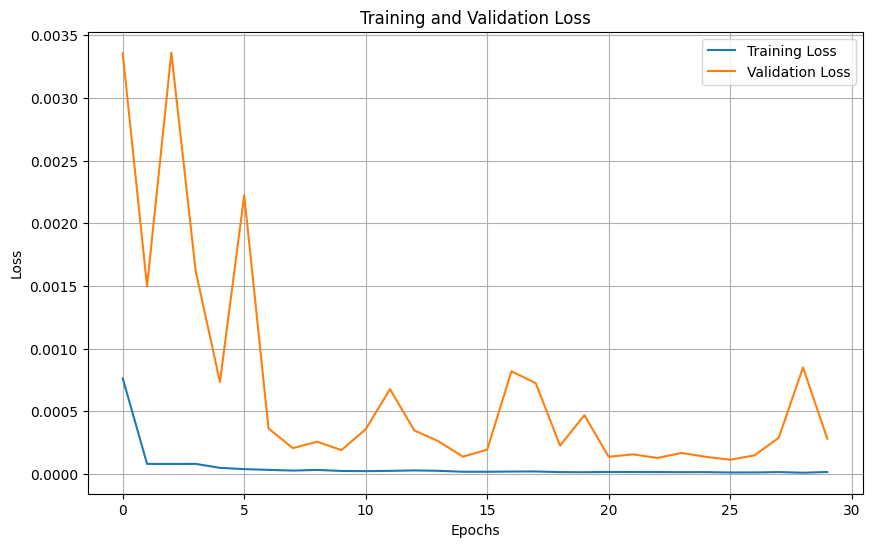

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [19]:
mse = np.mean((actuals - predictions) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actuals - predictions))
r2 = r2_score(actuals, predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

Test MSE: 1693.19
Test RMSE: 41.15
Test MAE: 32.22
R2 Score: 0.9329


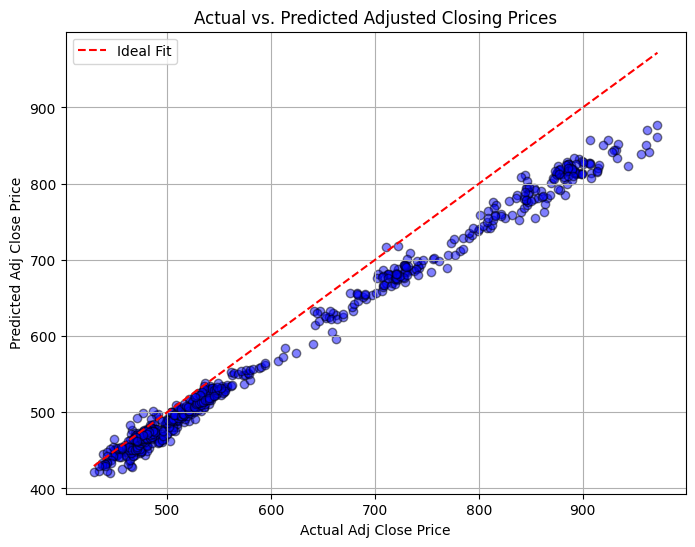

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, c='blue', edgecolors='k')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Adj Close Price")
plt.title("Actual vs. Predicted Adjusted Closing Prices")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True)
plt.show()

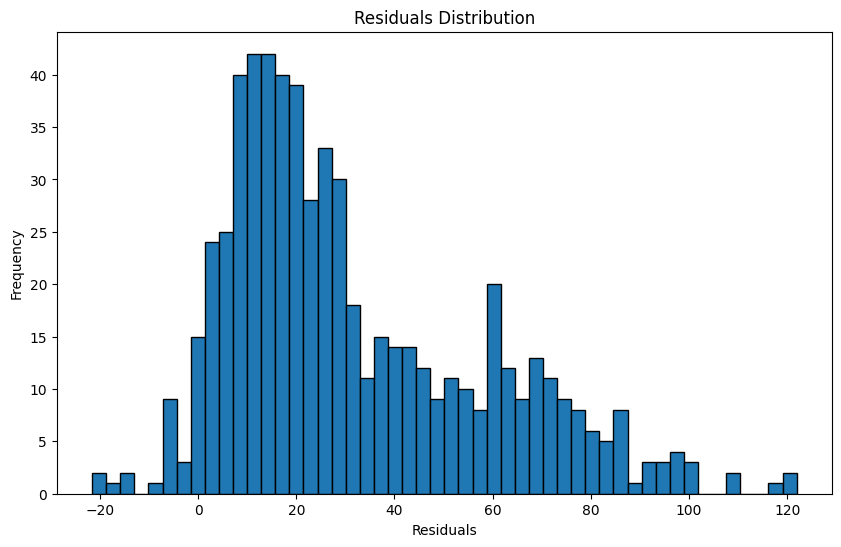

In [21]:
residuals = actuals - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

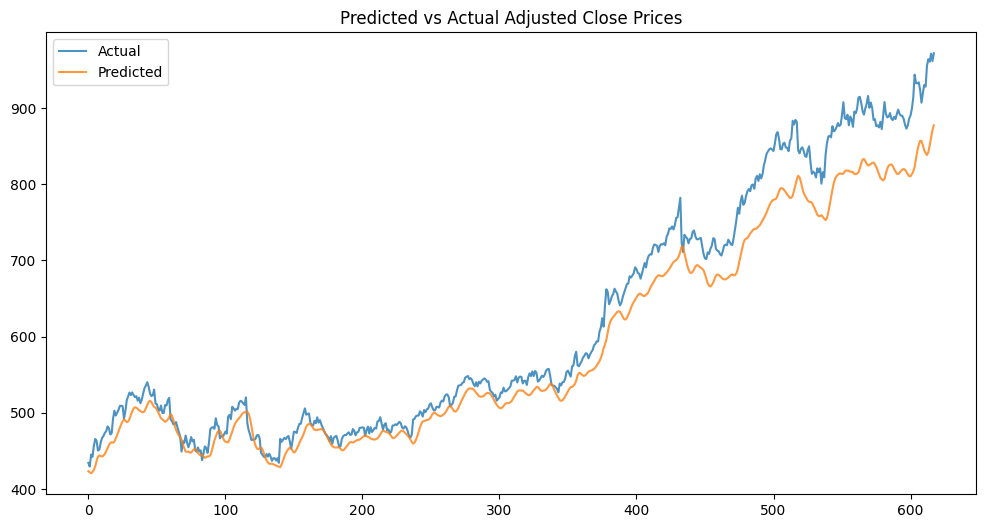

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Predicted vs Actual Adjusted Close Prices")
plt.legend()
plt.show()

Using CNN-LSTM Hybrid Arcitecture

In [119]:
seq_len = 90

features, targets = create_sequences(scaled_features, scaled_target, seq_len)

#print("Features Shape:", features.shape) 
#print("Targets Shape:", targets.shape)    

In [120]:
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

#print("Train Set:", X_train.shape, y_train.shape)
#print("Validation Set:", X_val.shape, y_val.shape)
#print("Test Set:", X_test.shape, y_test.shape)

In [100]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [101]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, kernel_size, hidden_size, num_layers=2, dropout=0.3):
        super(CNNLSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size, padding=0)
        self.conv2 = nn.Conv1d(in_channels=conv_filters, out_channels=conv_filters, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm1d(conv_filters)
        
        self.elu = nn.ELU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # CNN: [batch, seq_len, input_size] -> [batch, input_size, seq_len]
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.elu(x)     
        x = self.pool(x)      

        x = self.conv2(x)
        x = self.elu(x)     
        x = self.pool(x)
        x = x.transpose(1, 2)  

        lstm_out, _ = self.lstm(x) 
        out = self.fc(lstm_out[:, -1, :])
        return out

In [102]:
model = CNNLSTM(
    input_size=X_train.shape[2], 
    conv_filters=8,             
    kernel_size=2,               
    hidden_size=256,              
    num_layers=2,                
    dropout=0.3                  
).to(device)

In [103]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #, weight_decay=1e-5)

In [104]:
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(sequences).squeeze(-1) 
        loss = criterion(outputs, targets)
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * sequences.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * sequences.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch 1/30, Train Loss: 0.001296, Val Loss: 0.001315
Epoch 2/30, Train Loss: 0.000100, Val Loss: 0.001235
Epoch 3/30, Train Loss: 0.000080, Val Loss: 0.002325
Epoch 4/30, Train Loss: 0.000090, Val Loss: 0.001186
Epoch 5/30, Train Loss: 0.000075, Val Loss: 0.001053
Epoch 6/30, Train Loss: 0.000074, Val Loss: 0.004984
Epoch 7/30, Train Loss: 0.000066, Val Loss: 0.001110
Epoch 8/30, Train Loss: 0.000058, Val Loss: 0.002250
Epoch 9/30, Train Loss: 0.000059, Val Loss: 0.000954
Epoch 10/30, Train Loss: 0.000057, Val Loss: 0.000906
Epoch 11/30, Train Loss: 0.000058, Val Loss: 0.001980
Epoch 12/30, Train Loss: 0.000049, Val Loss: 0.001511
Epoch 13/30, Train Loss: 0.000048, Val Loss: 0.001299
Epoch 14/30, Train Loss: 0.000063, Val Loss: 0.002013
Epoch 15/30, Train Loss: 0.000043, Val Loss: 0.001306
Epoch 16/30, Train Loss: 0.000043, Val Loss: 0.003978
Epoch 17/30, Train Loss: 0.000043, Val Loss: 0.002885
Epoch 18/30, Train Loss: 0.000036, Val Loss: 0.001605
Epoch 19/30, Train Loss: 0.000044, Va

In [105]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        outputs = model(sequences).squeeze(-1)
        predictions.extend(outputs.cpu().numpy())
        
        actuals.extend(targets.cpu().numpy())

predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

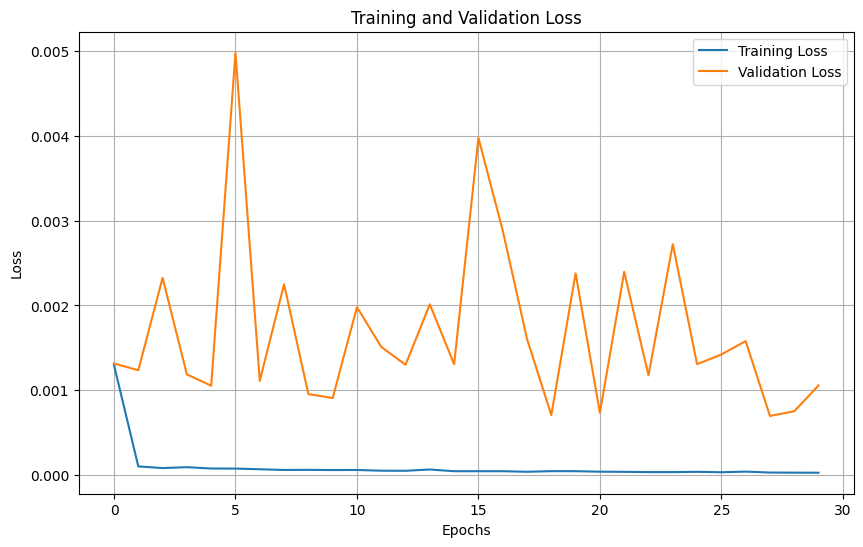

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [107]:
mse = np.mean((actuals - predictions) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actuals - predictions))
r2 = r2_score(actuals, predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

Test MSE: 2254.62
Test RMSE: 47.48
Test MAE: 38.18
R2 Score: 0.9106


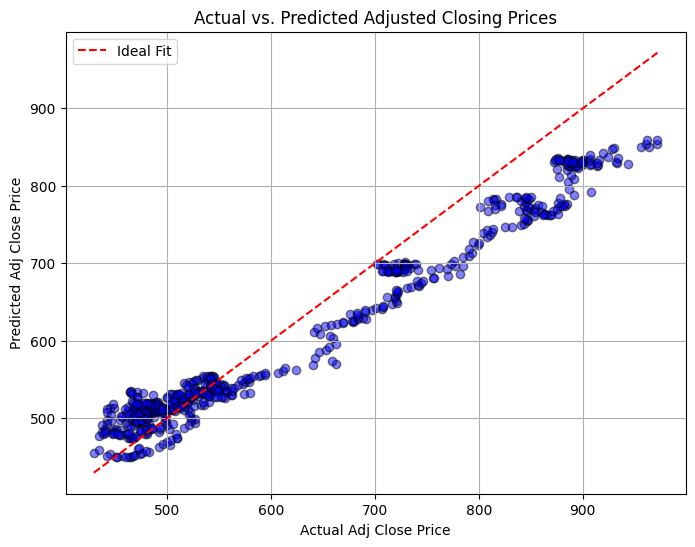

In [108]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, c='blue', edgecolors='k')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Adj Close Price")
plt.title("Actual vs. Predicted Adjusted Closing Prices")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True)
plt.show()

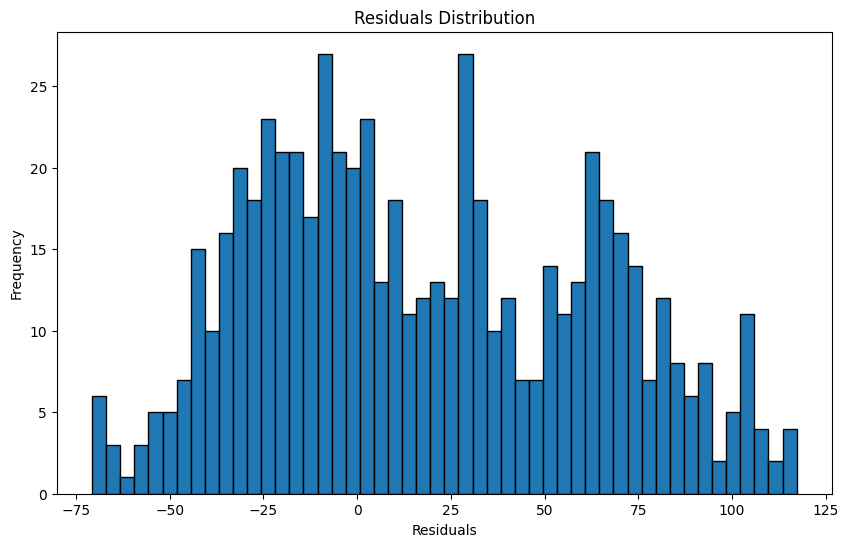

In [109]:
residuals = actuals - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

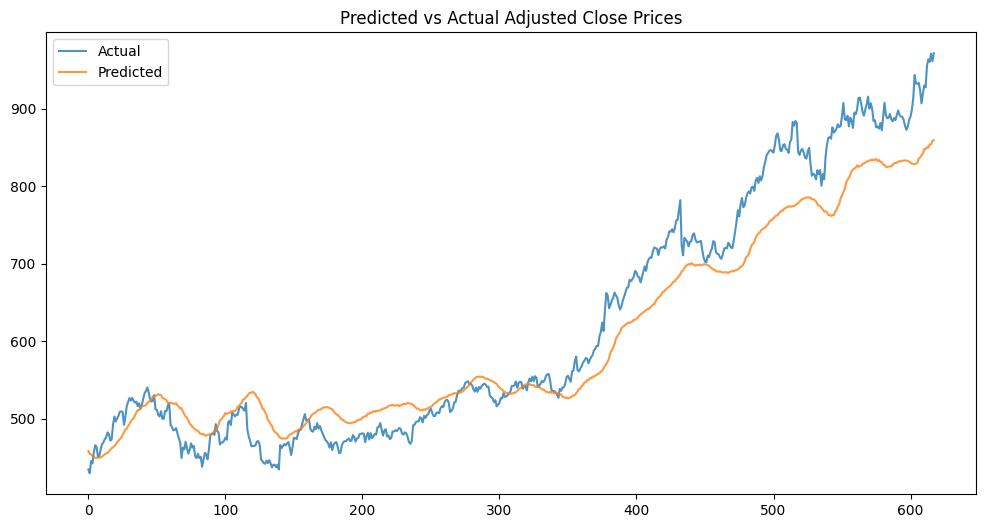

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Predicted vs Actual Adjusted Close Prices")
plt.legend()
plt.show()

Using GRU Arcitecture

In [121]:
seq_len = 90
features, targets = create_sequences(scaled_features, scaled_target, seq_len)
#print("Features Shape:", features.shape) 
#print("Targets Shape:", targets.shape)    

In [122]:
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

#print("Train Set:", X_train.shape, y_train.shape)
#print("Validation Set:", X_val.shape, y_val.shape)
#print("Test Set:", X_test.shape, y_test.shape)

In [38]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
        super(GRU, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  
        out = self.fc(out)   
        return out

In [40]:
model = GRU(
    input_size=X_train.shape[2],             
    hidden_size=256,             
    num_layers=2,                
    dropout=0.3                  
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [41]:
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(sequences).squeeze(-1)  
        loss = criterion(outputs, targets)
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        optimizer.step()
        train_loss += loss.item() * sequences.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * sequences.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch 1/30, Train Loss: 0.001348, Val Loss: 0.006056
Epoch 2/30, Train Loss: 0.000125, Val Loss: 0.004814
Epoch 3/30, Train Loss: 0.000091, Val Loss: 0.002170
Epoch 4/30, Train Loss: 0.000061, Val Loss: 0.001192
Epoch 5/30, Train Loss: 0.000051, Val Loss: 0.001328
Epoch 6/30, Train Loss: 0.000035, Val Loss: 0.000489
Epoch 7/30, Train Loss: 0.000028, Val Loss: 0.000839
Epoch 8/30, Train Loss: 0.000026, Val Loss: 0.000338
Epoch 9/30, Train Loss: 0.000024, Val Loss: 0.000501
Epoch 10/30, Train Loss: 0.000019, Val Loss: 0.000505
Epoch 11/30, Train Loss: 0.000025, Val Loss: 0.000639
Epoch 12/30, Train Loss: 0.000021, Val Loss: 0.000288
Epoch 13/30, Train Loss: 0.000020, Val Loss: 0.000205
Epoch 14/30, Train Loss: 0.000016, Val Loss: 0.000231
Epoch 15/30, Train Loss: 0.000021, Val Loss: 0.000556
Epoch 16/30, Train Loss: 0.000017, Val Loss: 0.000453
Epoch 17/30, Train Loss: 0.000019, Val Loss: 0.000201
Epoch 18/30, Train Loss: 0.000014, Val Loss: 0.000147
Epoch 19/30, Train Loss: 0.000019, Va

In [42]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for sequences, targets in test_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        outputs = model(sequences).squeeze(-1)
        predictions.extend(outputs.cpu().numpy())
        
        actuals.extend(targets.cpu().numpy())

predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

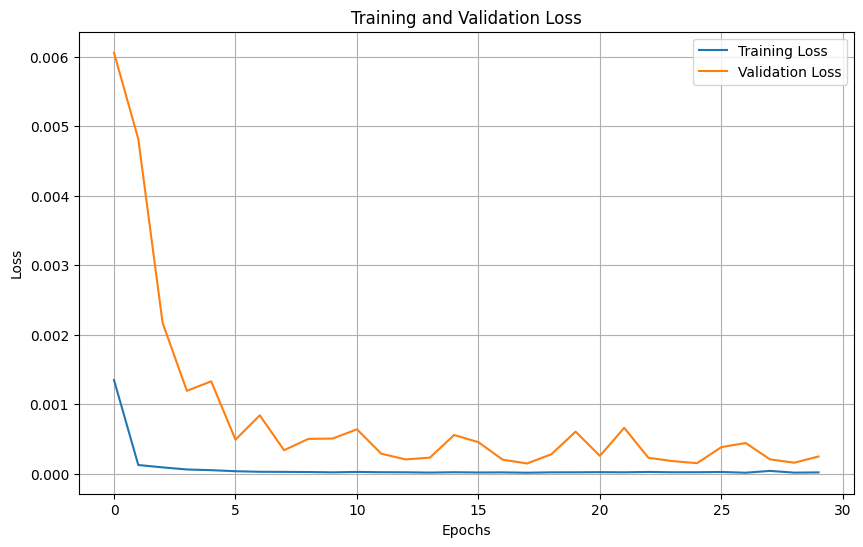

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [44]:
mse = np.mean((actuals - predictions) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actuals - predictions))
r2 = r2_score(actuals, predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

Test MSE: 509.21
Test RMSE: 22.57
Test MAE: 17.29
R2 Score: 0.9798


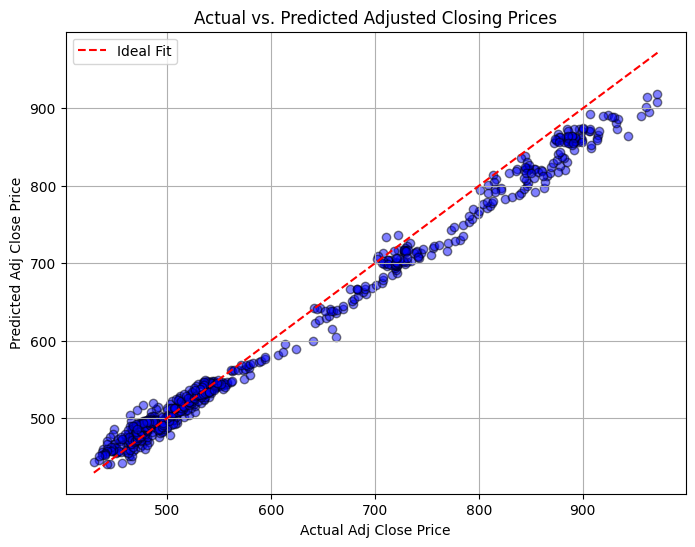

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, c='blue', edgecolors='k')
plt.xlabel("Actual Adj Close Price")
plt.ylabel("Predicted Adj Close Price")
plt.title("Actual vs. Predicted Adjusted Closing Prices")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True)
plt.show()

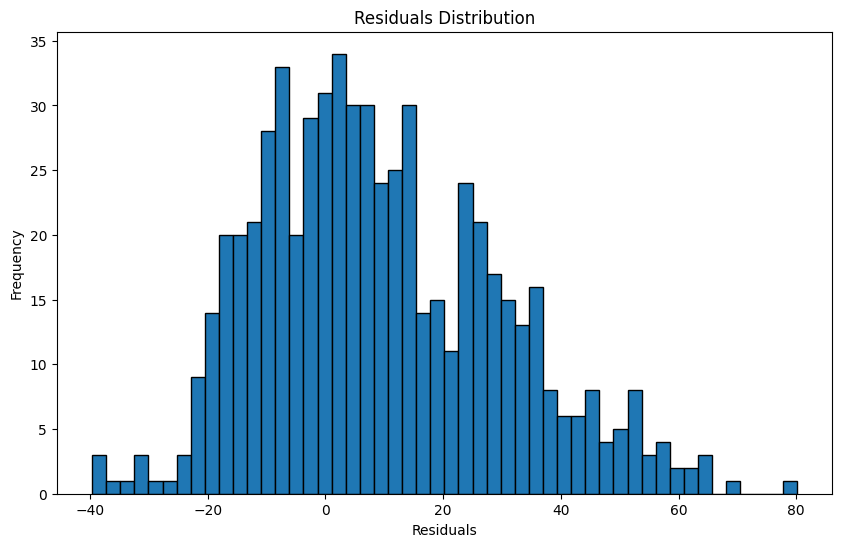

In [46]:
residuals = actuals - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

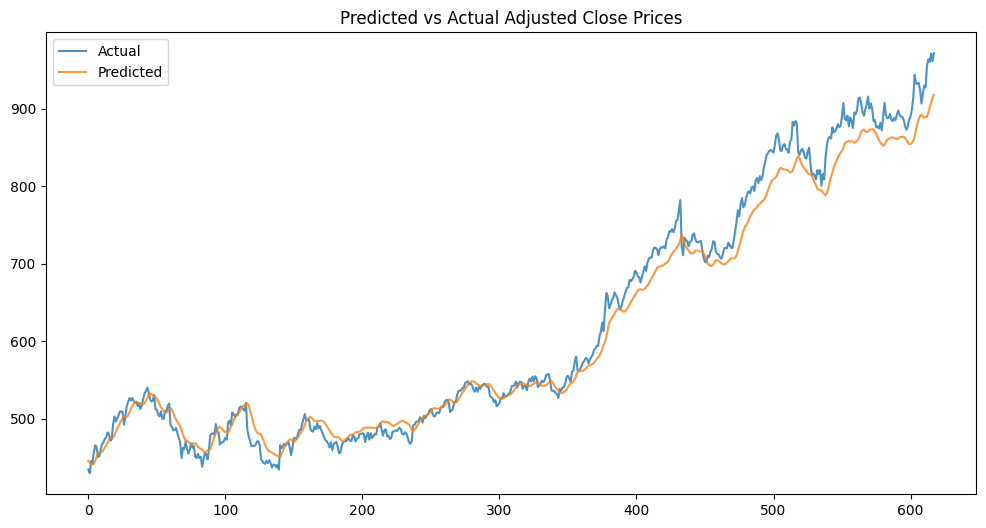

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Predicted vs Actual Adjusted Close Prices")
plt.legend()
plt.show()